In [100]:
import os

from astropy.visualization import ZScaleInterval

os.environ['CRDS_PATH'] = "/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/CRDS/"
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

import stdatamodels.jwst.datamodels as dm
import numpy as np
import matplotlib.pyplot as plt
import BNBG.Pipeline.BetterBackgroundSubtractStep as BBStep
from scipy.ndimage import median_filter
from scipy.stats import median_abs_deviation as mad

In [2]:
path = "/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/jw01345063001_03101_00003_nrs2_resamplespecstep_temp.fits"
model = dm.open(path)

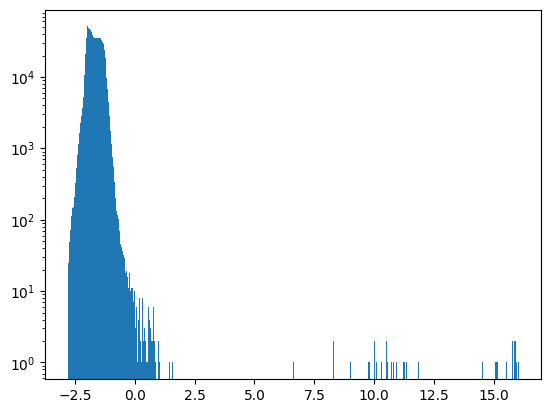

In [3]:
err = np.array([])

for i, slit in enumerate(model.slits):
	err = np.append(err, slit.err.ravel())

err = err[np.isfinite(err)]
plt.figure()
plt.hist(np.log10(err), bins=500)
plt.yscale('log')
plt.show()

2024-12-17 18:09:55,852 - stpipe - INFO -  - [BetterBackground]  : Finished Interpolation with 100 iterations, found S = 0.029061666014855846


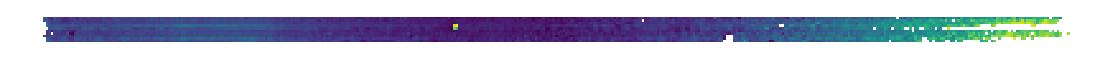

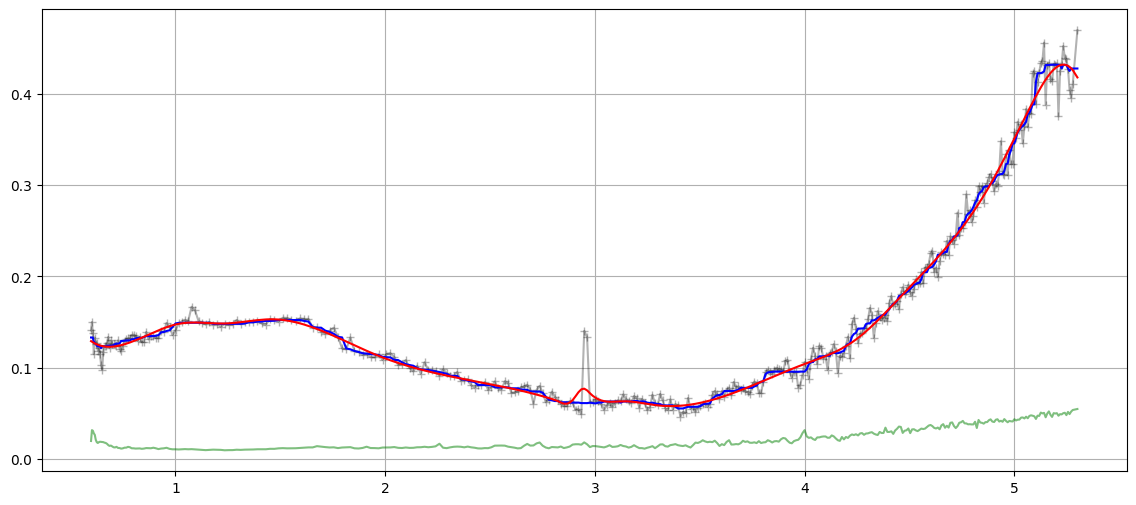

In [98]:

for i,slit in enumerate(model.slits):
	if i != 2:
		continue
	data = slit.data.copy()
	error = slit.err.copy()
	Y, X = np.indices(slit.data.shape)
	_, _, wavelength = slit.meta.wcs.transform("detector", "world", X, Y)
	source = BBStep.getSourcePosition(slit)

	x,y,dy = BBStep.getDataWithMask(data, error, wavelength, source=source)

	median = median_filter(y,size=15)

	plt.figure(figsize=(14,2))
	plt.imshow(data, origin='lower', cmap='viridis', interpolation='none')
	plt.axis('off')

	plt.figure(figsize=(14,6))
	plt.plot(x,y,marker='+',alpha=0.3,color='k')
	plt.plot(x,dy,alpha=0.5,color='g')
	plt.plot(x,median,color='b')
	plt.grid()

	w = 1/dy
	w /= w.mean()
	interp = BBStep.makeInterpolation(x, y, w,n=0.05)

	plt.plot(x,interp(x),color='r')

	plt.show()

In [136]:
def masking(data, error, crop=3, source=None, radius=5, percent=99):
	plt.figure(figsize=(18,3))
	z1, z2 = ZScaleInterval().get_limits(data)
	plt.imshow(data, origin='lower', cmap='viridis', interpolation='none', vmin=z1, vmax=z2)

	Y, X = np.indices(data.shape)
	# Gets rid of negative values, crops the top and bottom of the image, ignores pixels marked as nan
	indices = np.where(data <= 0)
	plt.scatter(indices[1], indices[0], color='k', marker='s')

	mask = (data <= 0) | (Y < crop) | (Y > Y.max() - crop) | np.isnan(data)

	# If source in the image, remove lines in a radius around
	# This also works if the source is not in frame and the returned position is 1e48
	if source is not None:
		mask = mask | (np.round(abs(Y - source)) < radius)

	# Removes top 1% highest error values in already kept values
	error[mask] = np.nan
	_ = error[np.isfinite(error)]
	cut = np.percentile(_, percent)
	mask = mask | (error > cut)

	indices = np.where(error > cut)
	plt.scatter(indices[1], indices[0], color='b', marker='+')

	median = median_filter(data,size=(1,5),mode="nearest")
	img = data - median
	median_dev = img.ravel()
	median_dev = median_dev[np.isfinite(median_dev)]
	std = 15*mad(median_dev)
	indices = np.where(np.abs(img) > std)
	plt.scatter(indices[1], indices[0], color='r', marker='.')

	plt.axis('off')


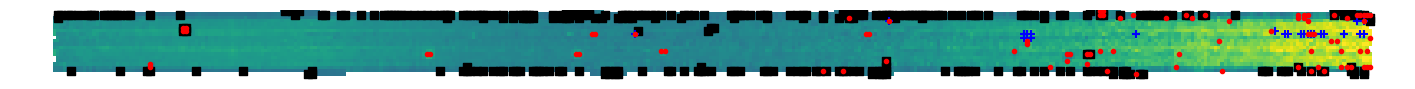

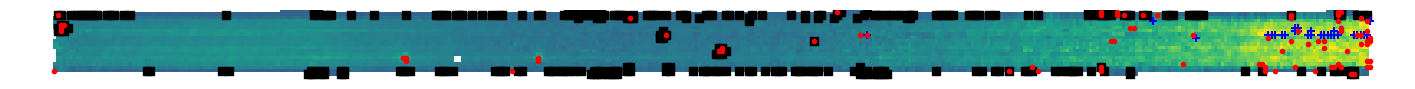

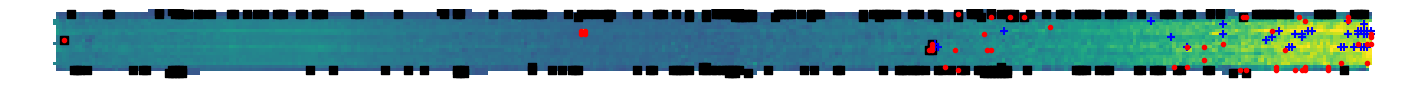

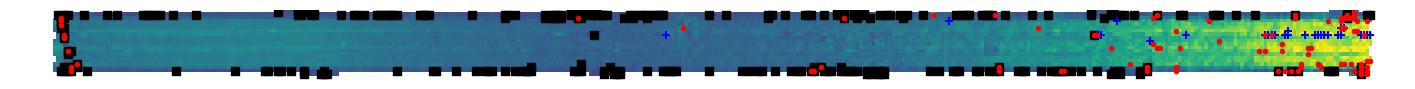

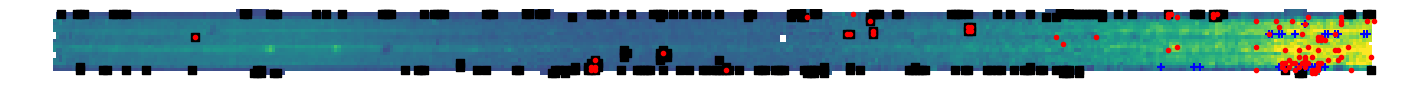

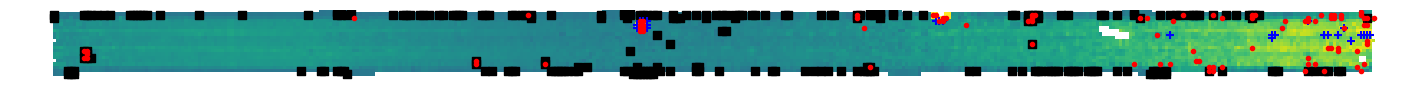

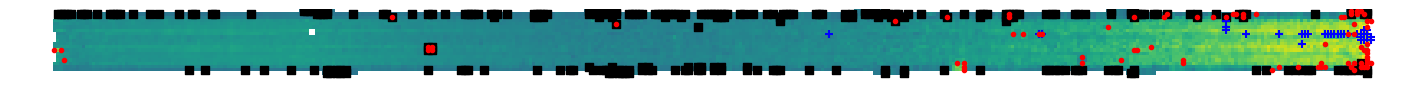

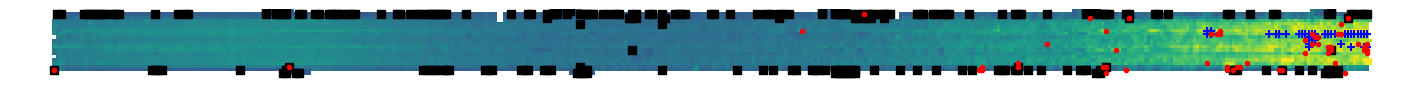

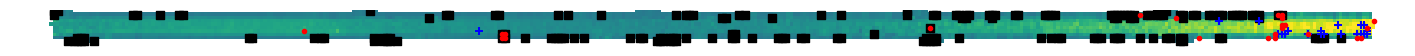

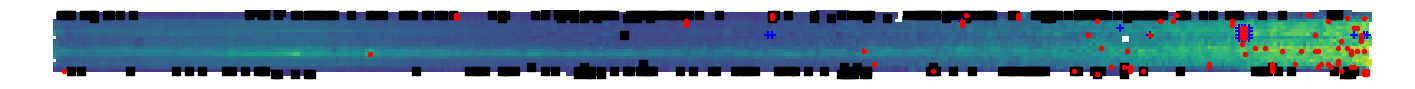

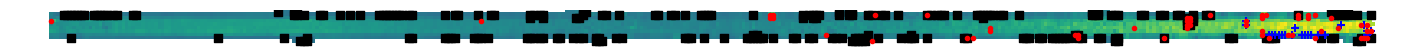

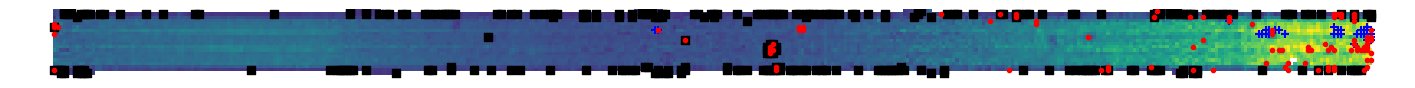

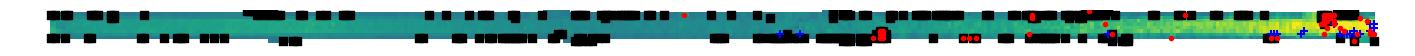

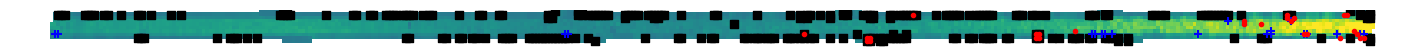

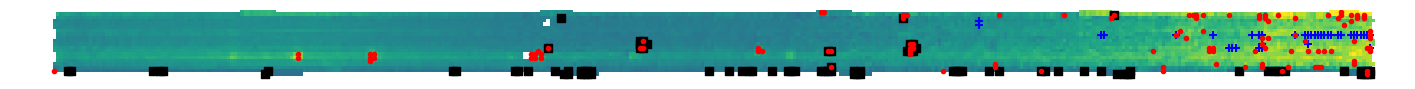

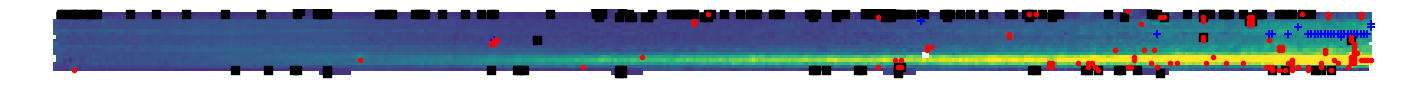

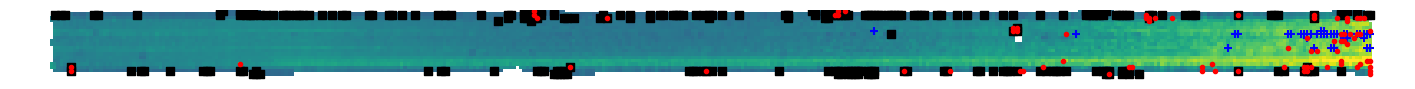

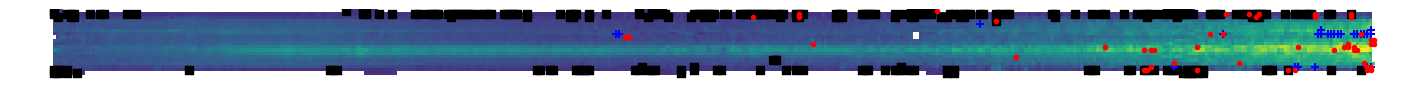

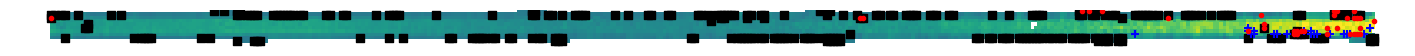

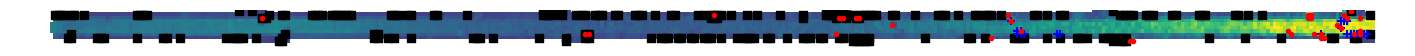

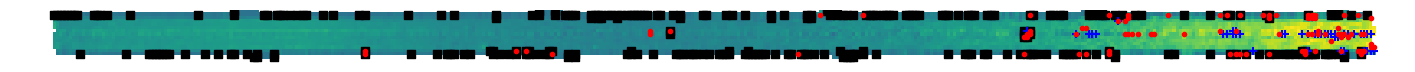

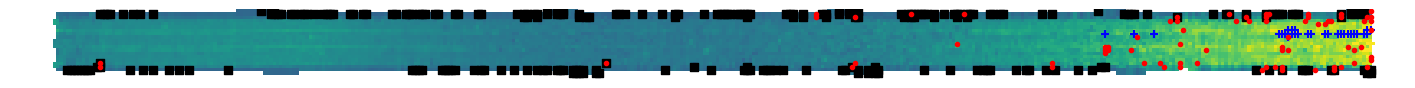

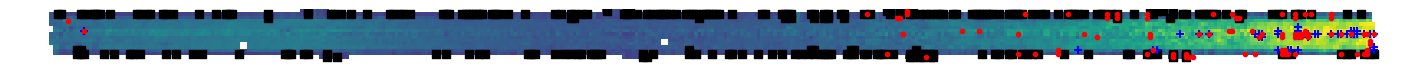

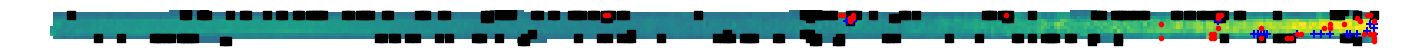

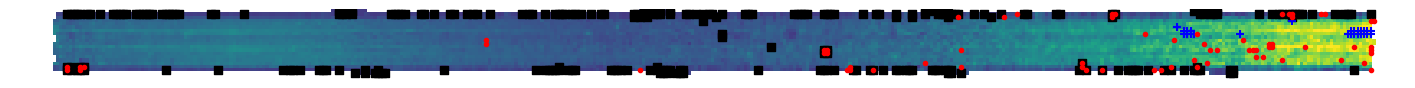

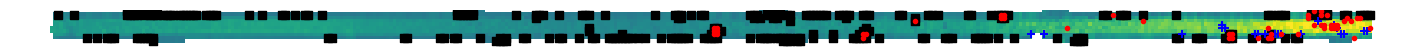

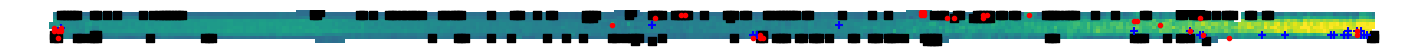

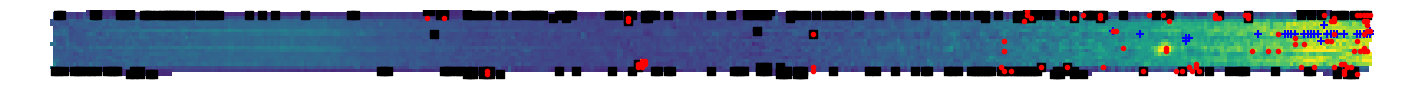

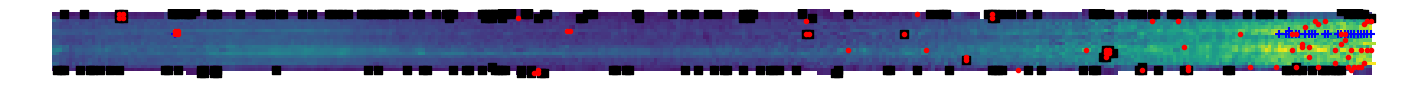

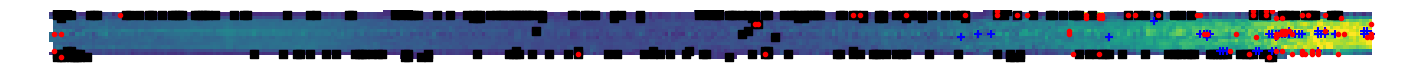

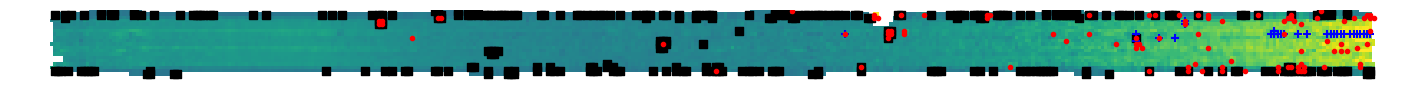

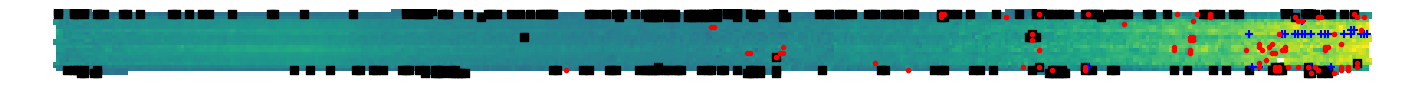

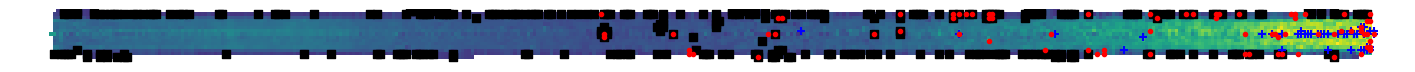

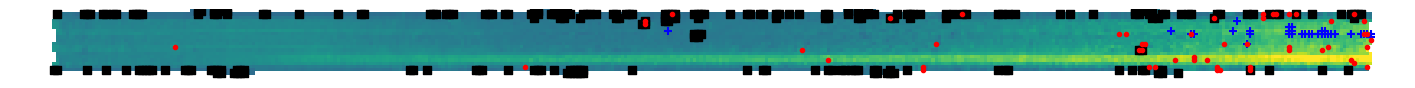

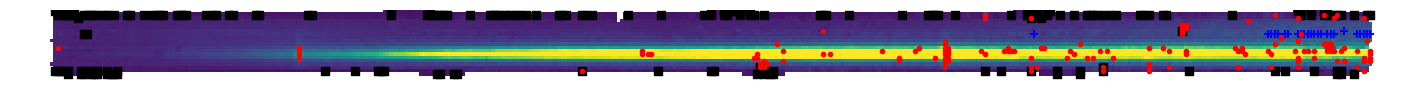

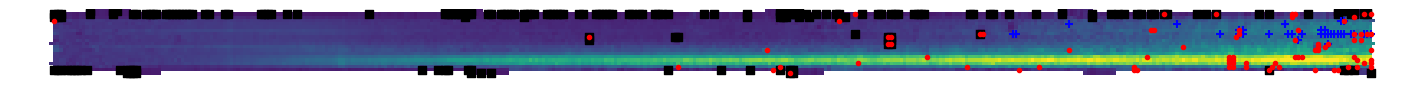

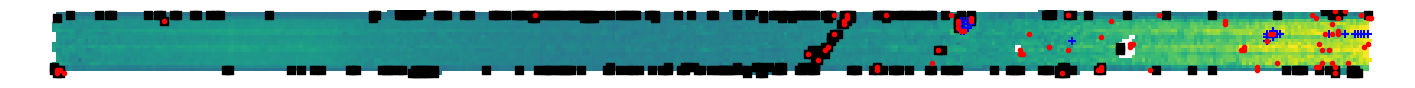

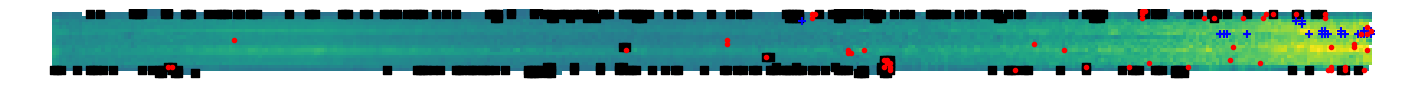

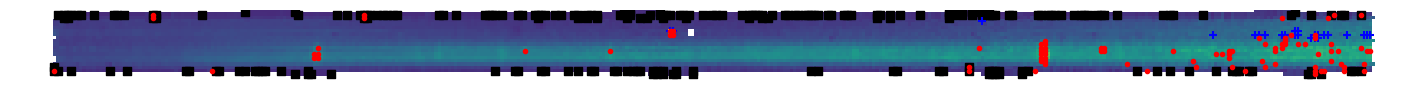

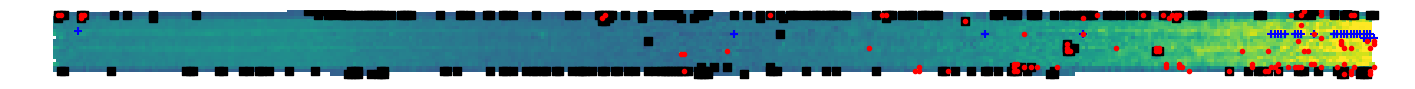

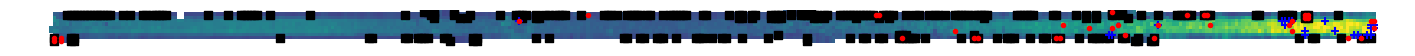

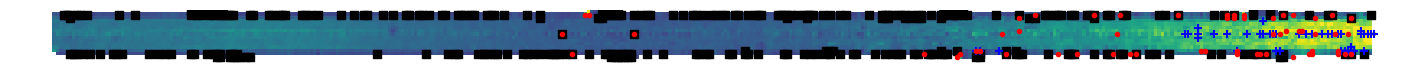

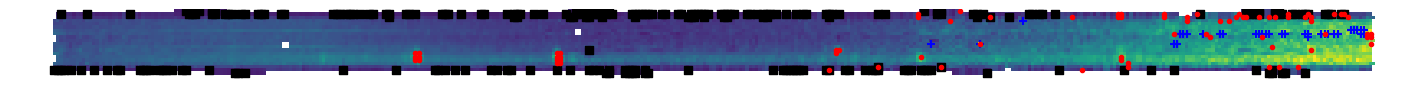

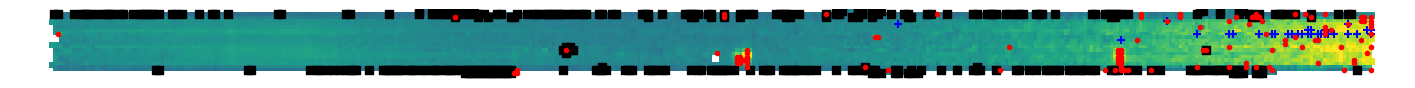

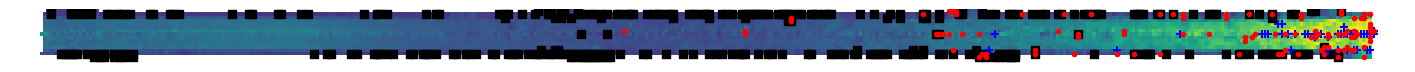

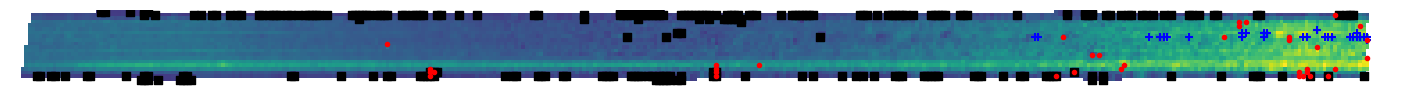

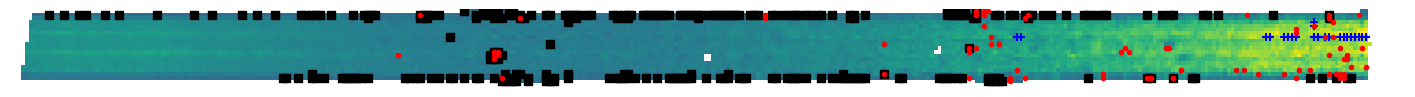

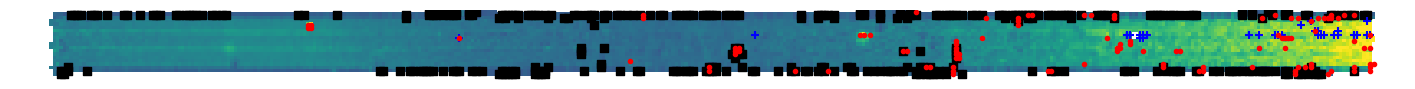

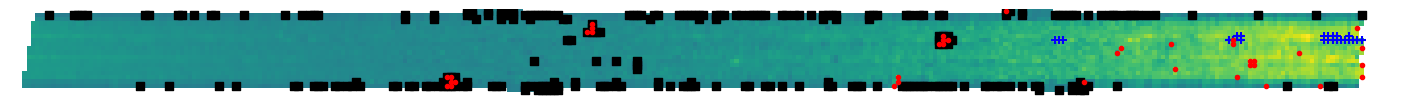

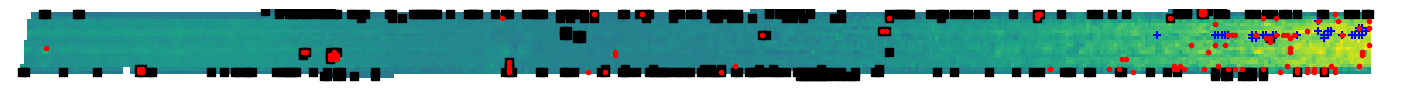

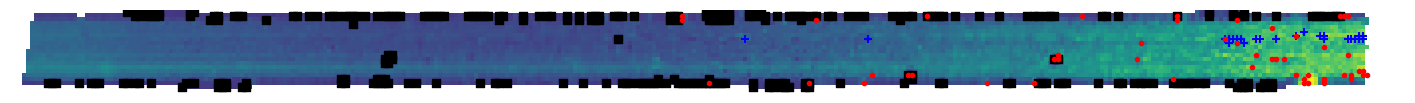

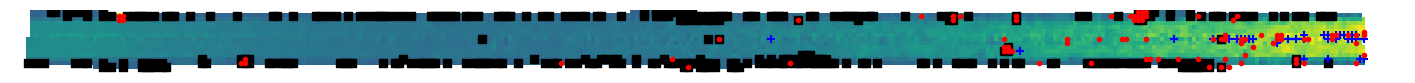

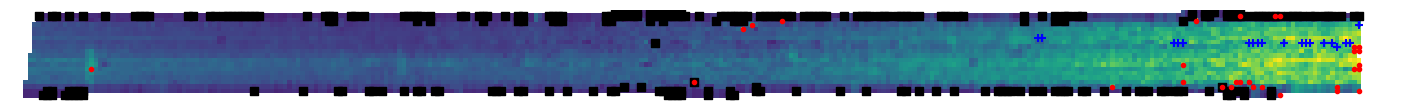

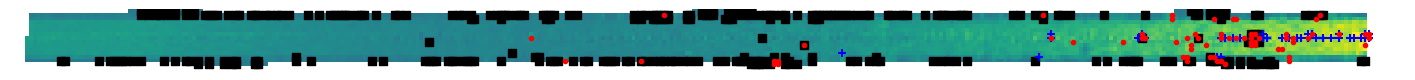

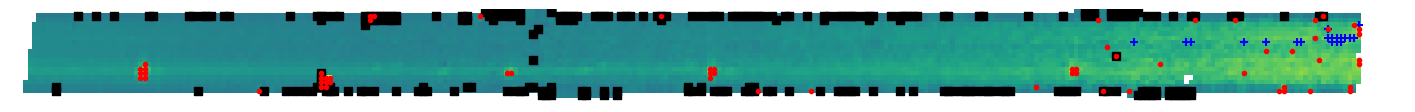

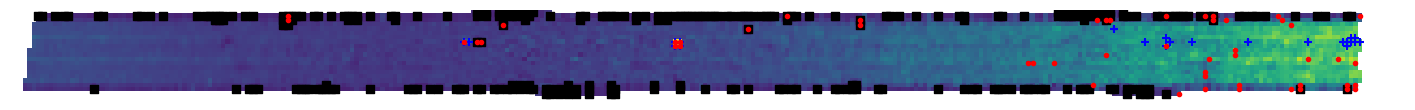

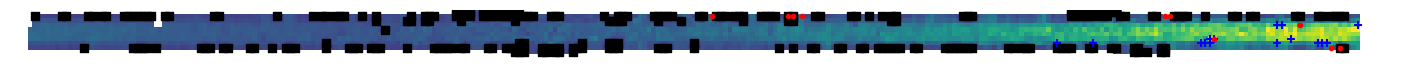

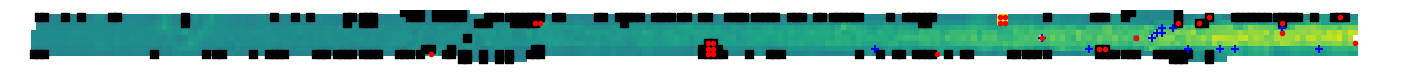

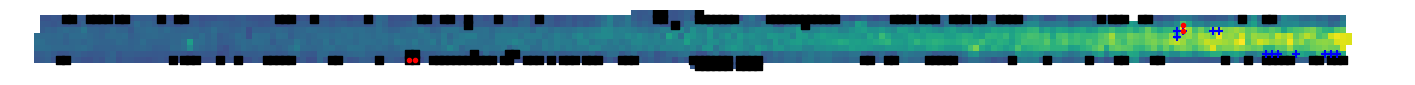

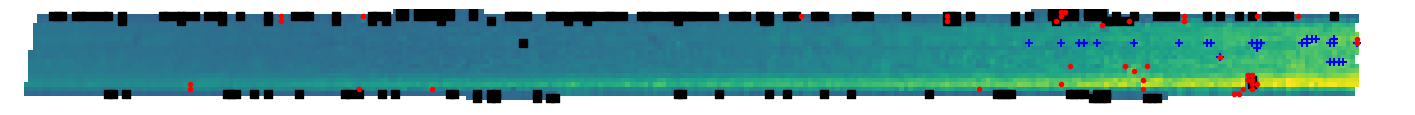

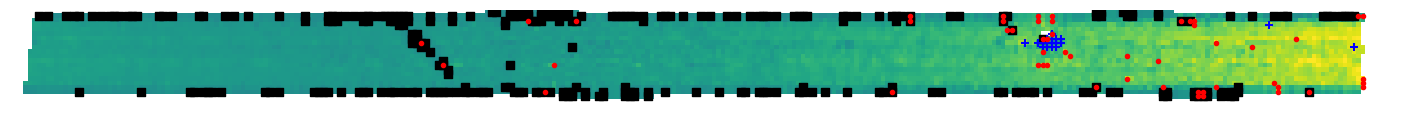

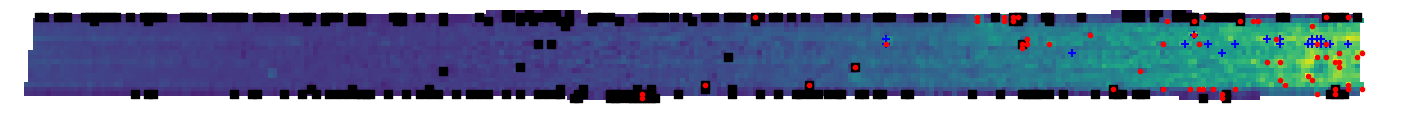

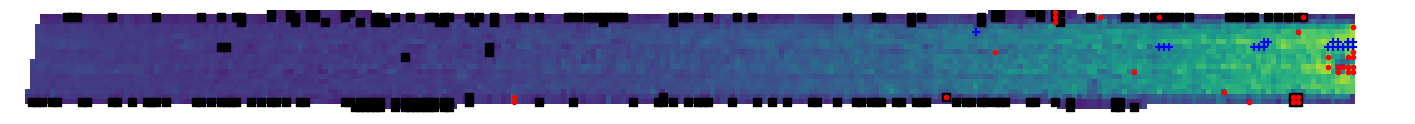

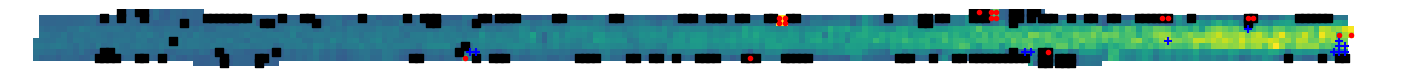

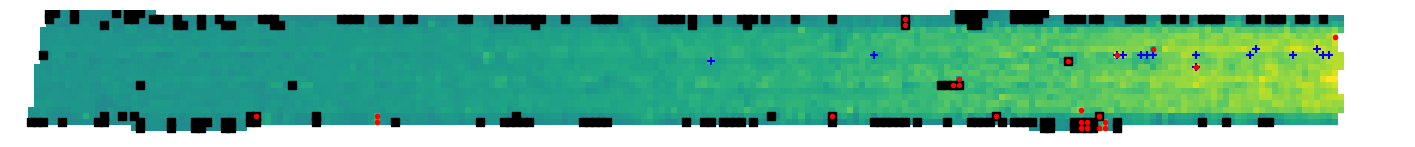

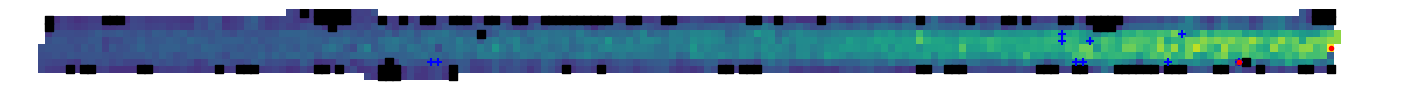

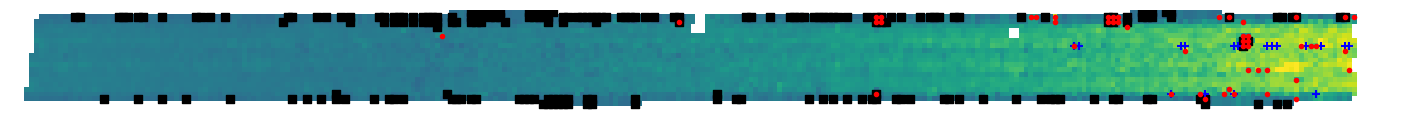

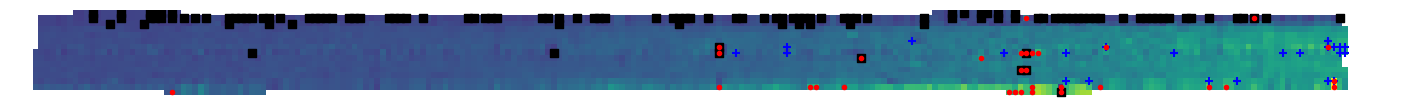

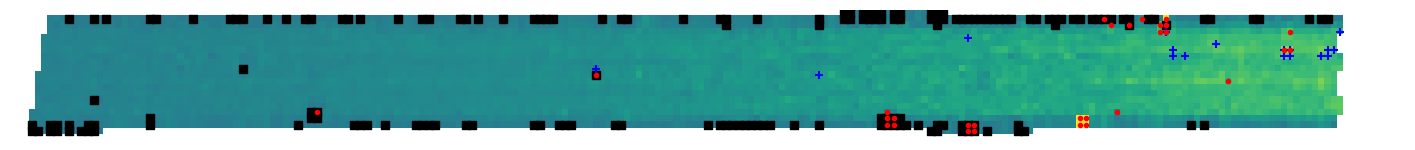

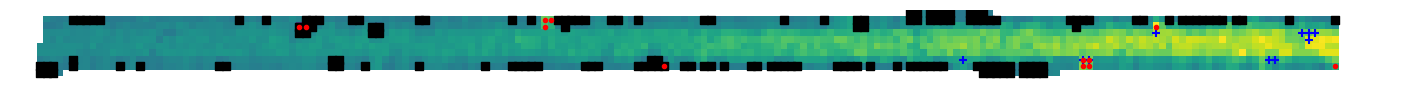

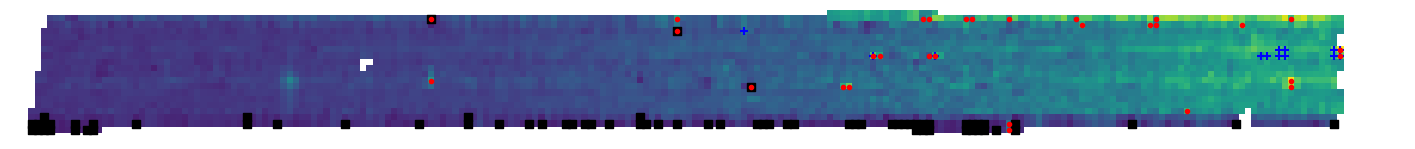

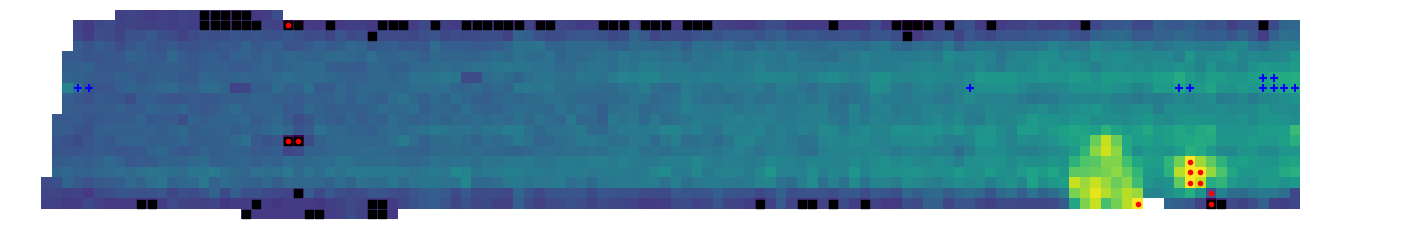

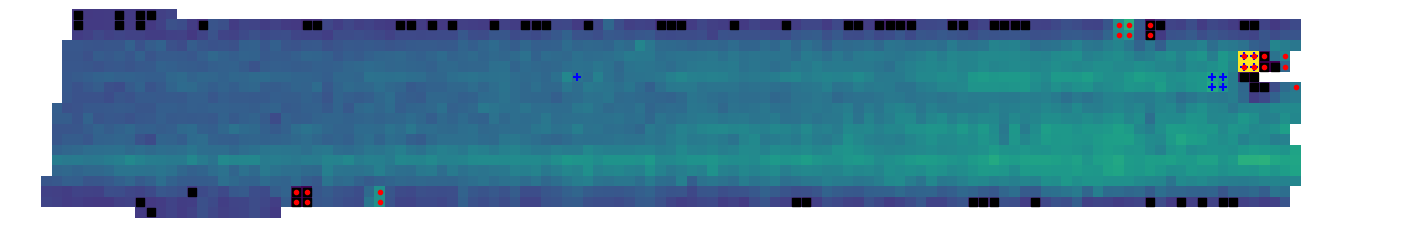

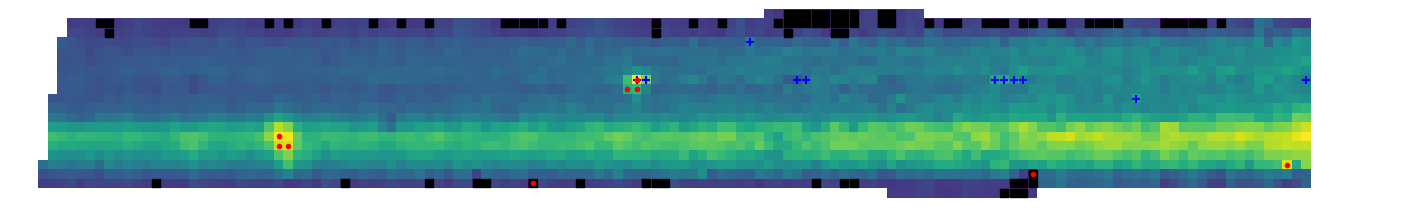

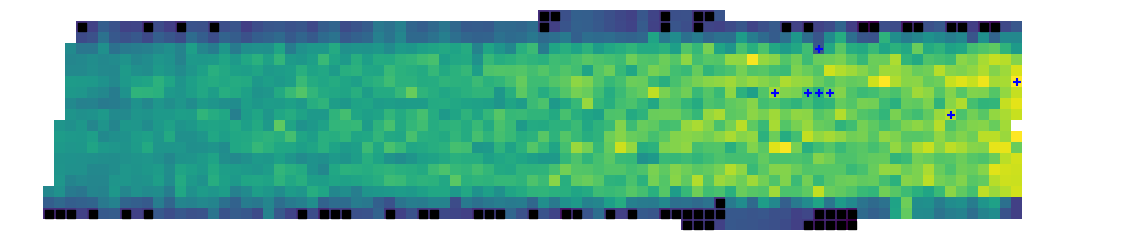

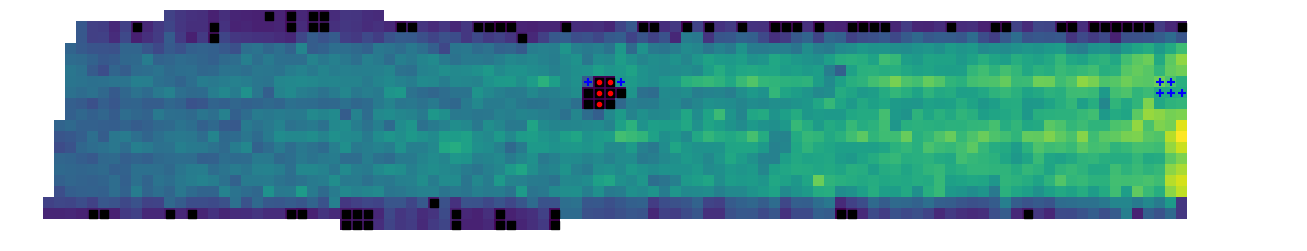

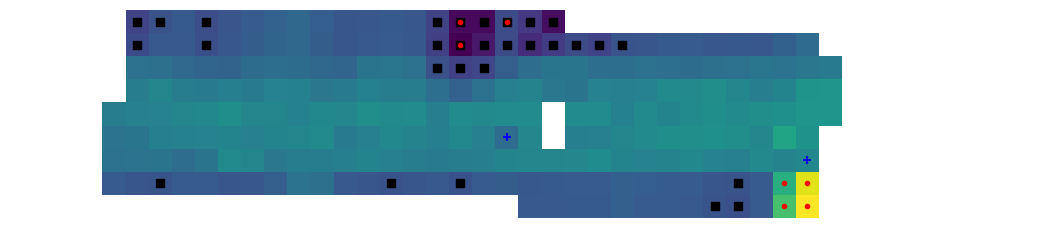

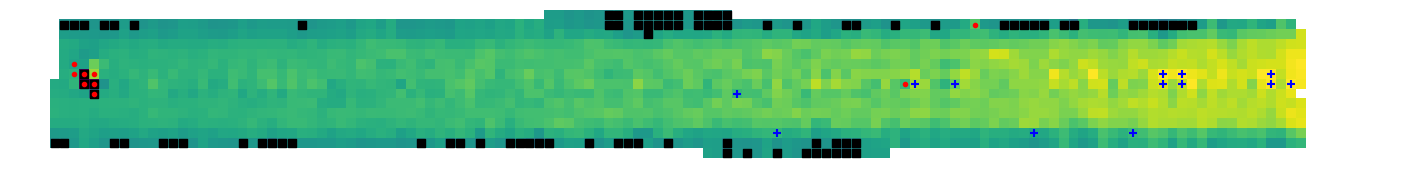

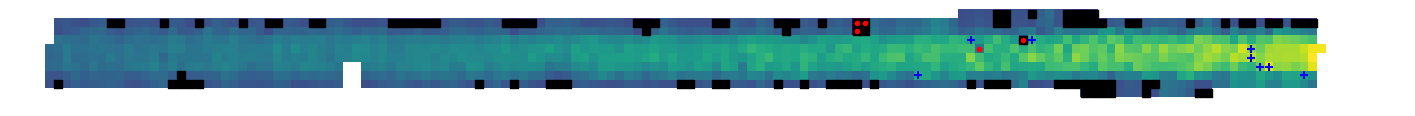

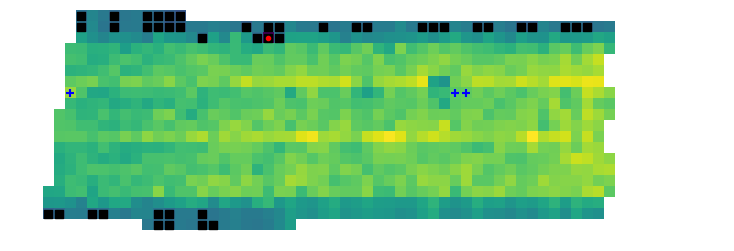

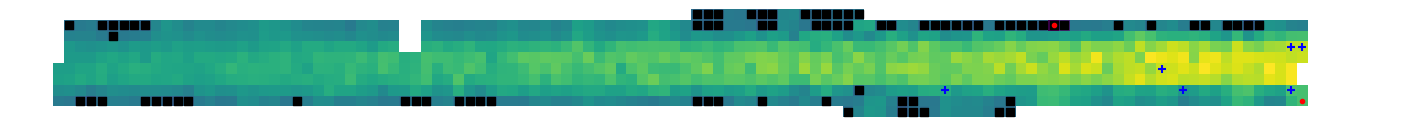

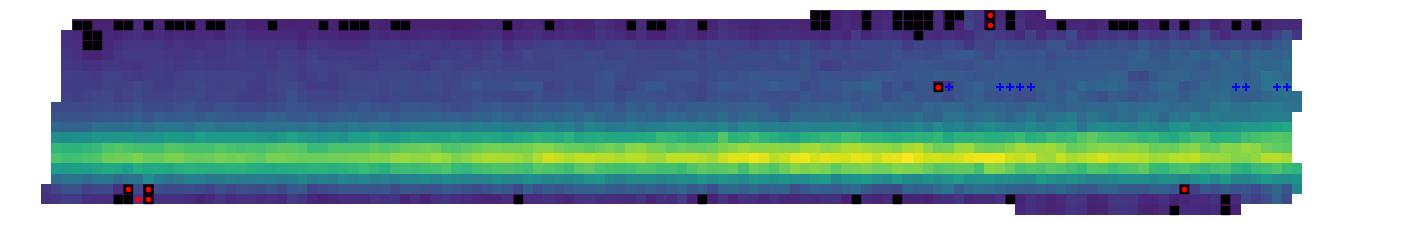

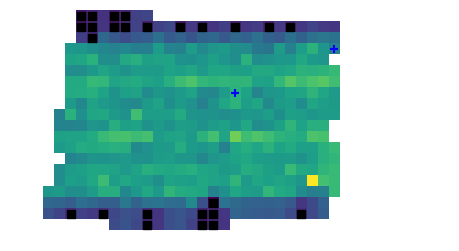

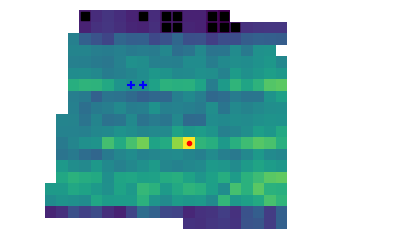

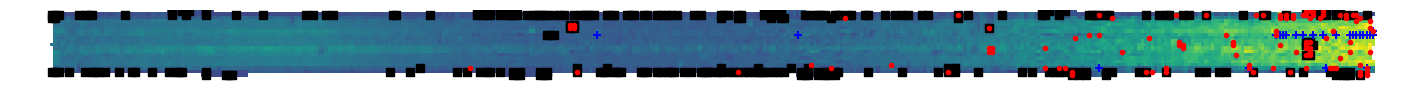

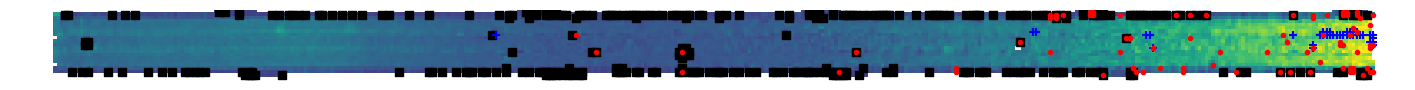

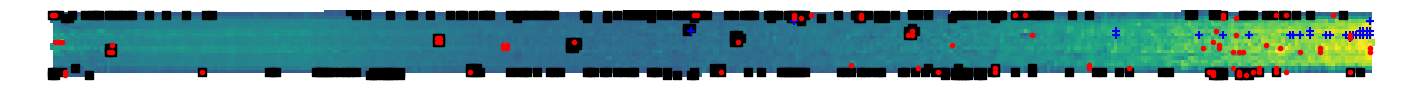

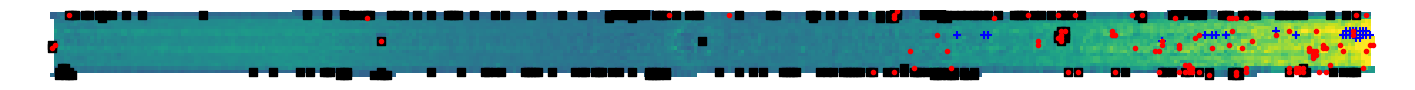

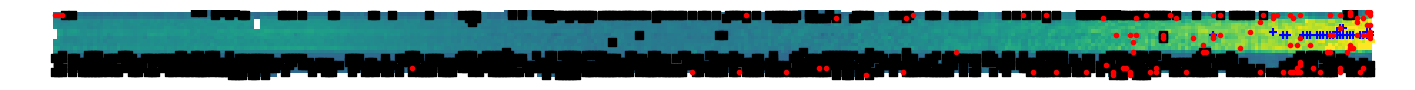

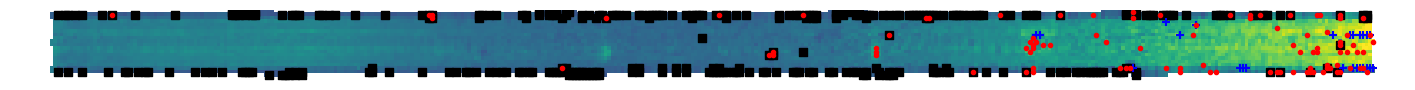

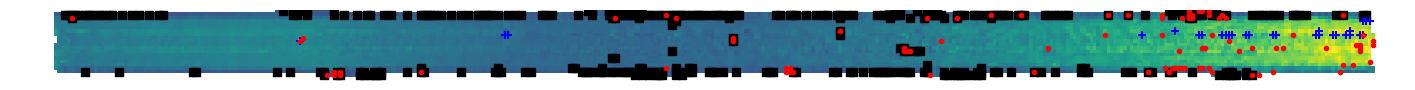

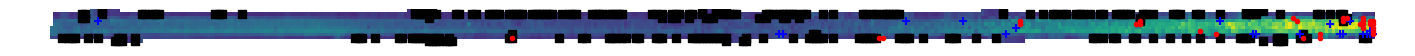

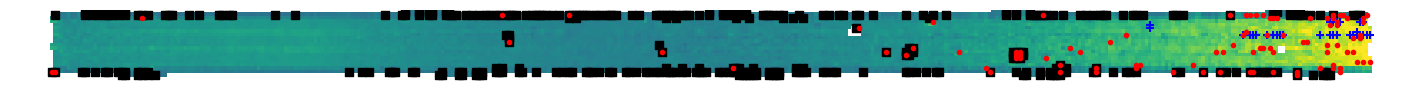

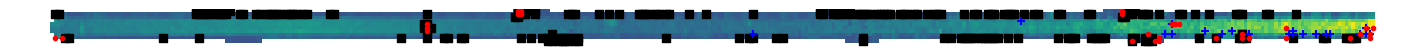

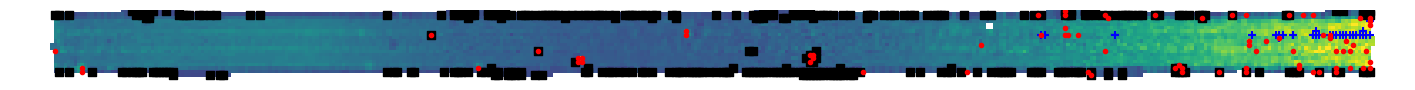

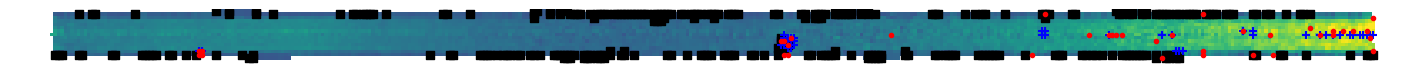

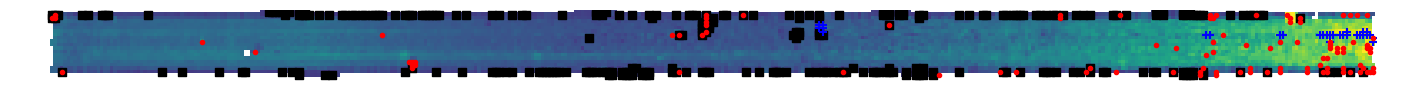

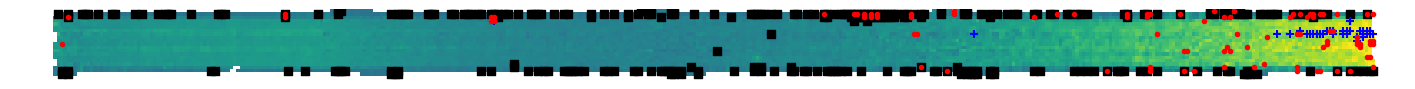

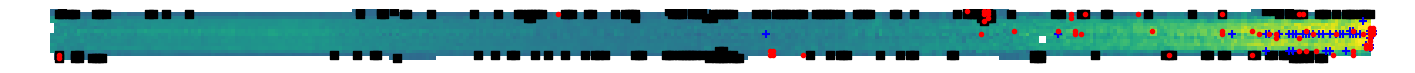

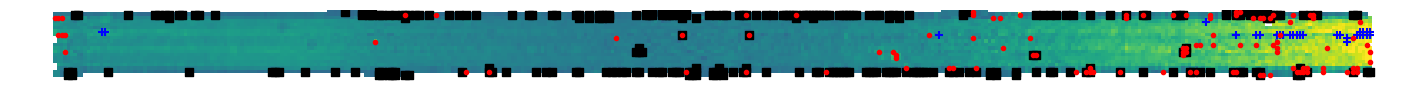

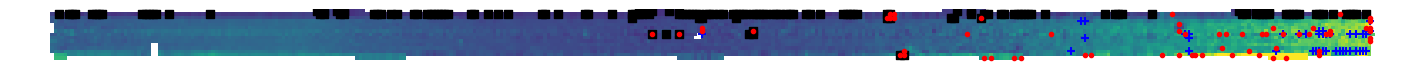

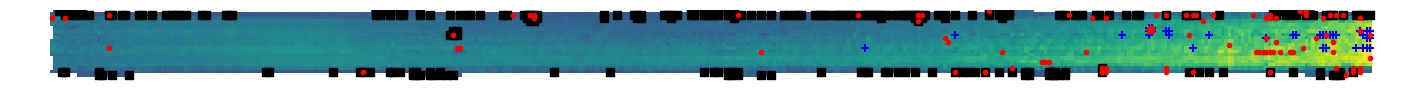

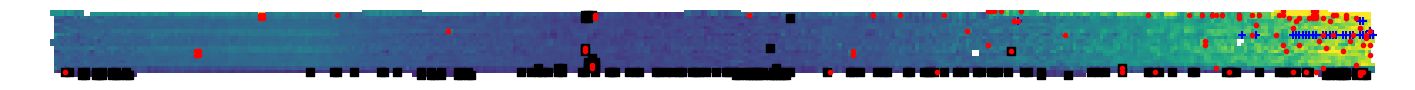

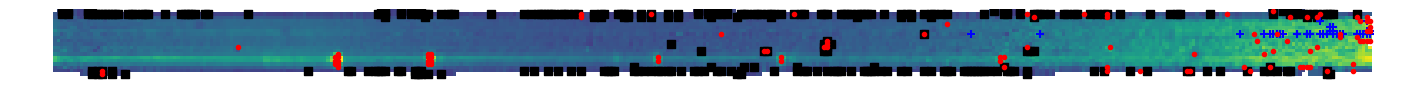

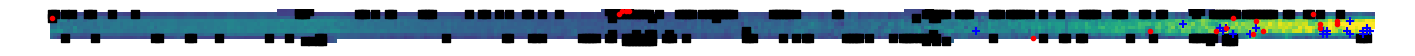

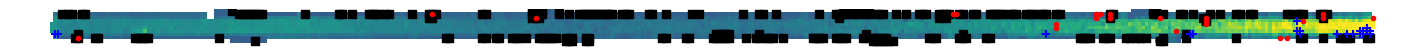

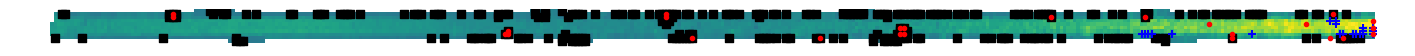

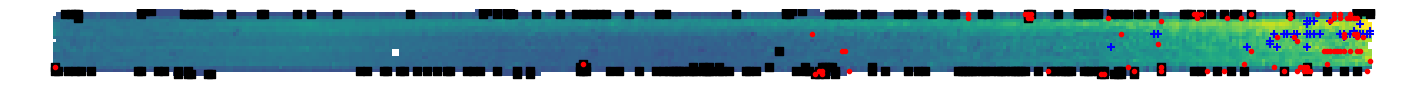

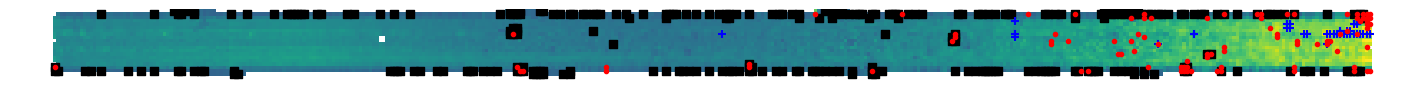

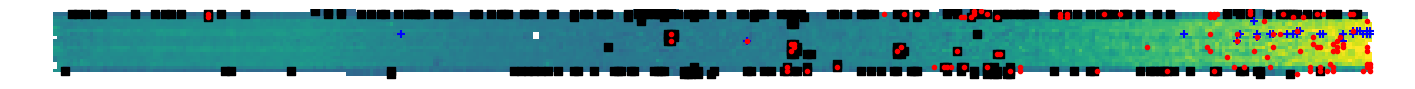

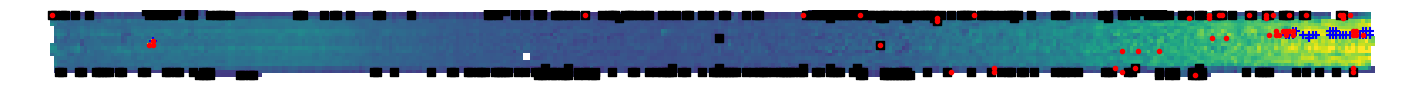

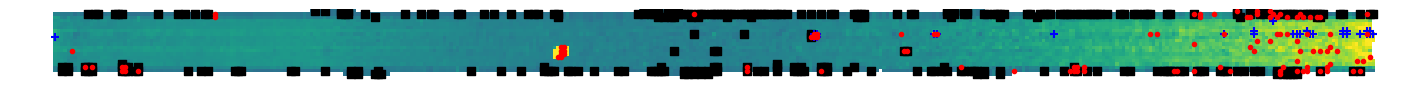

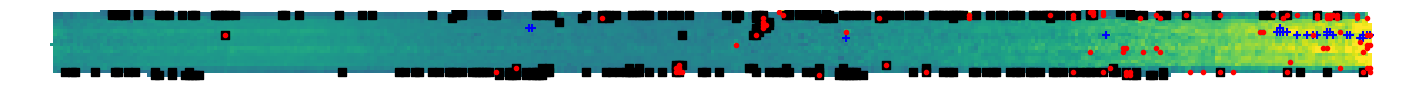

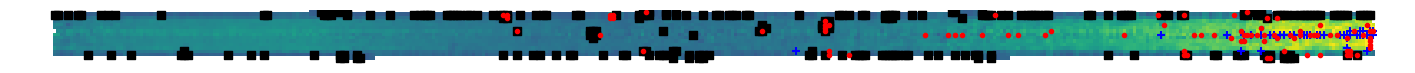

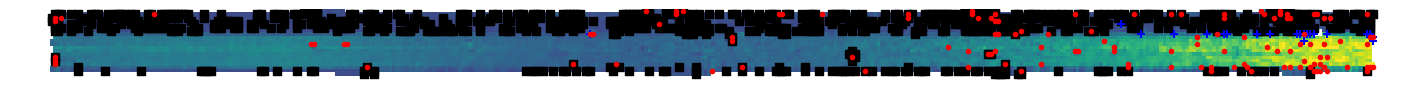

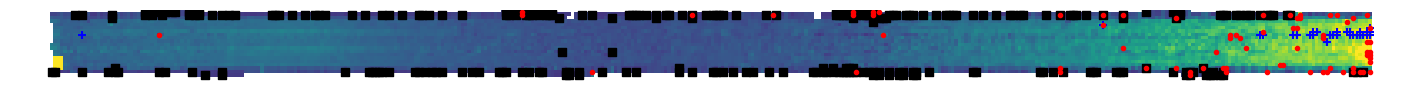

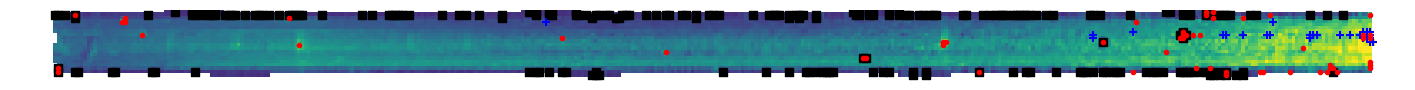

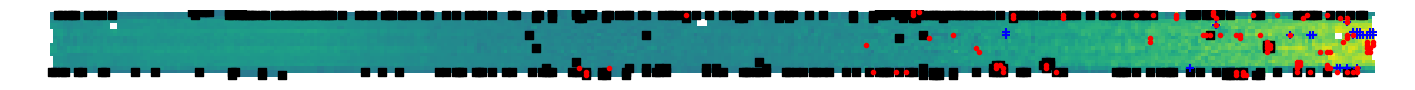

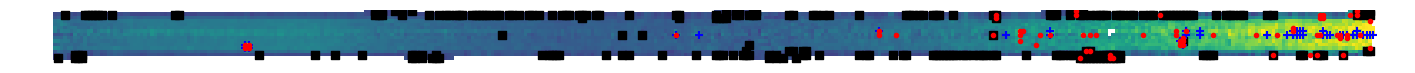

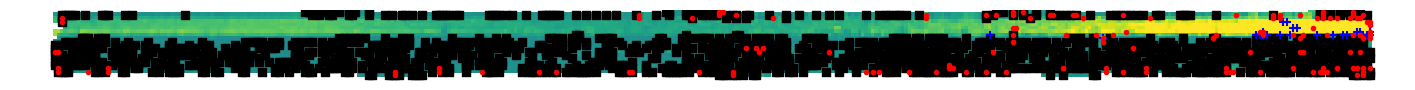

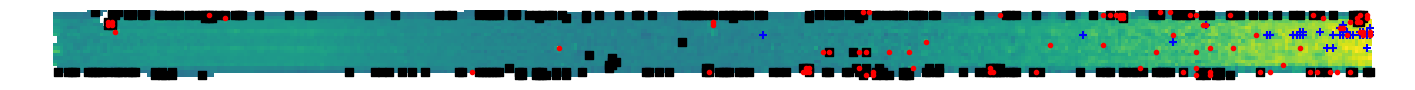

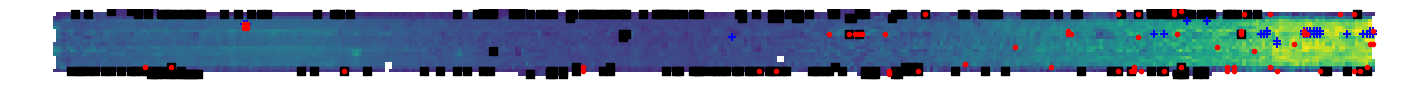

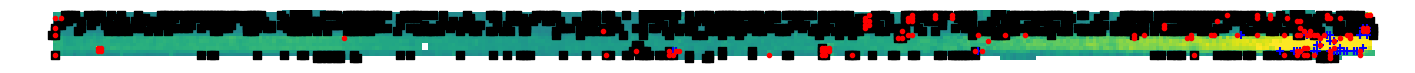

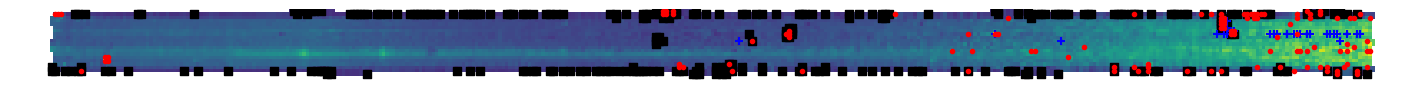

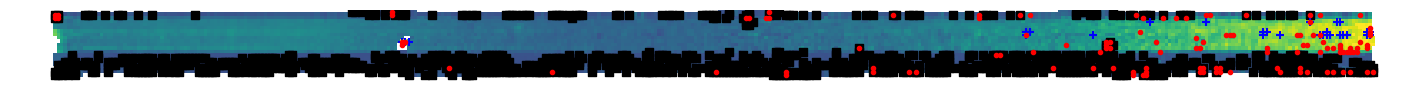

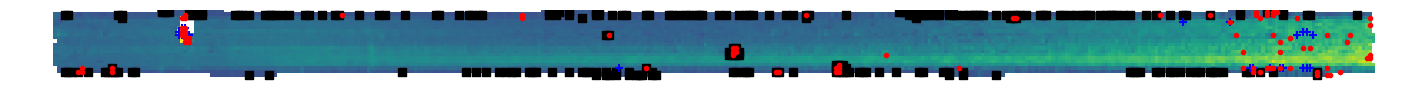

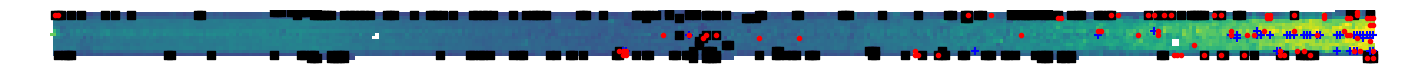

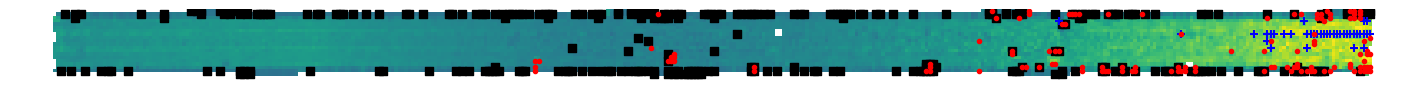

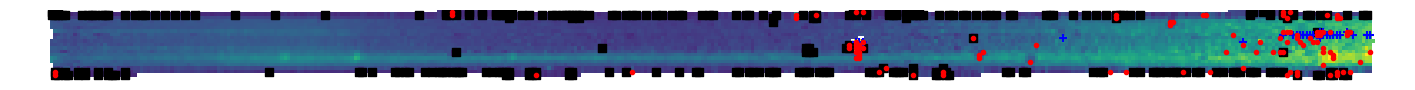

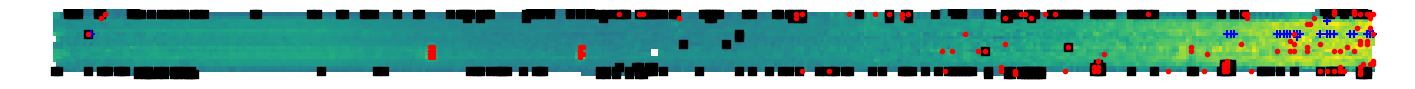

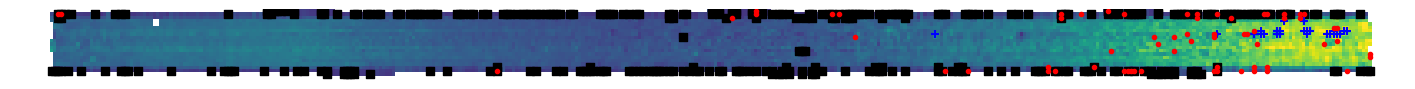

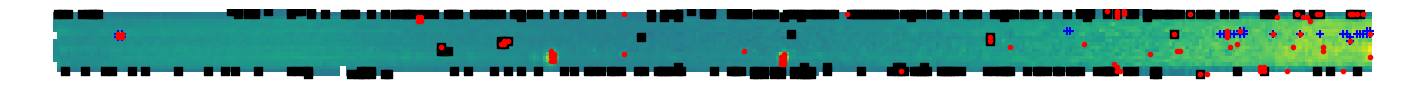

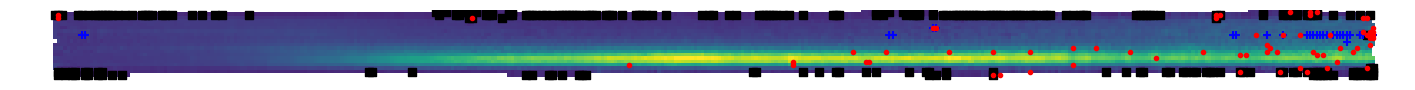

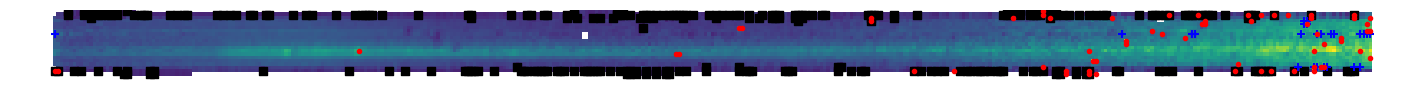

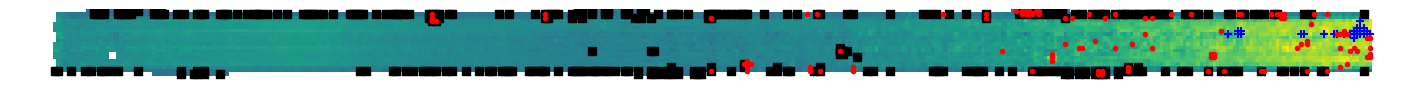

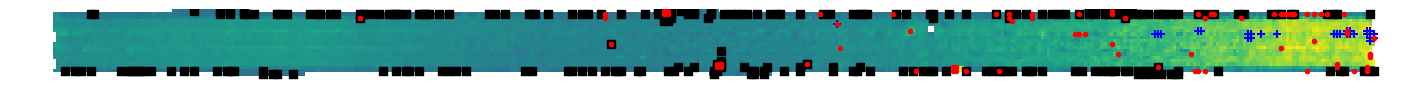

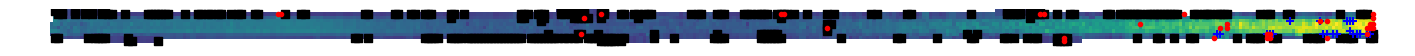

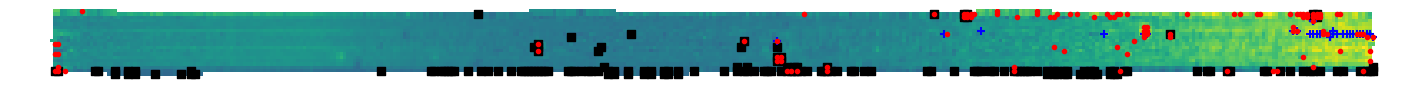

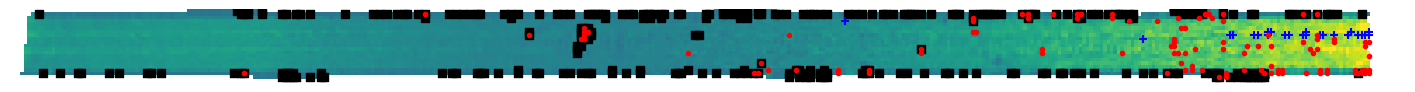

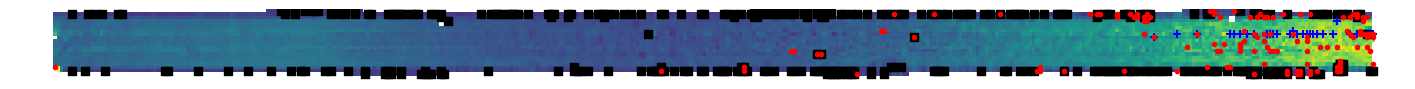

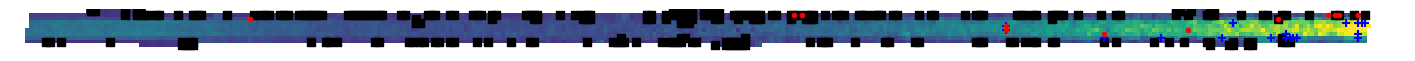

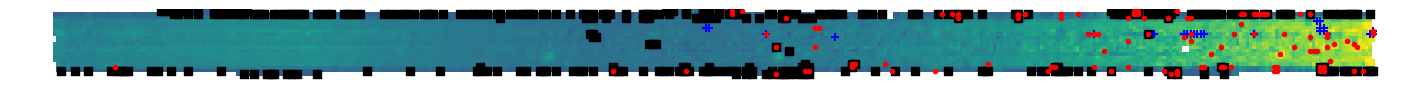

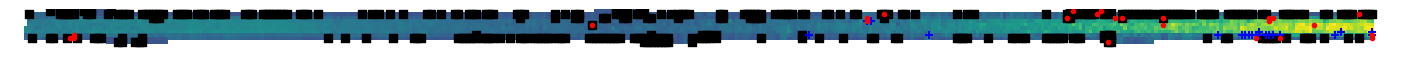

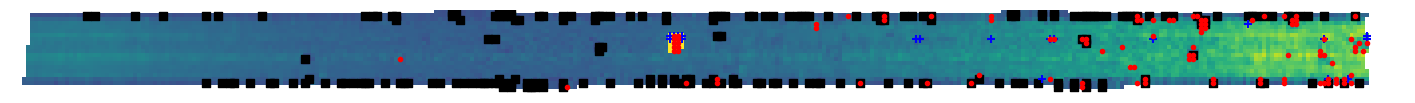

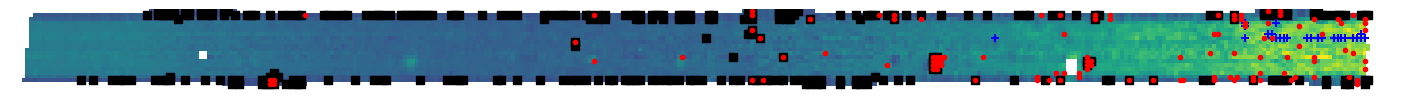

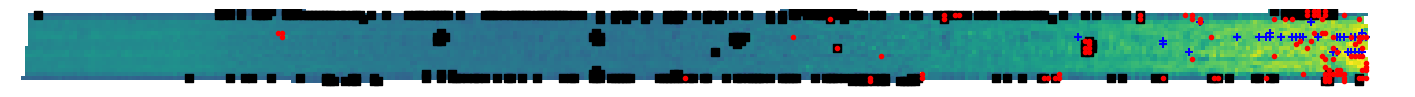

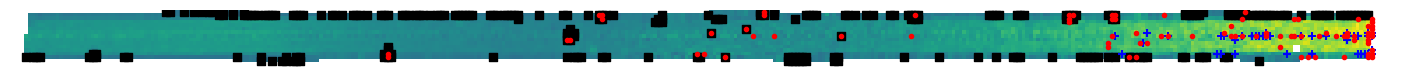

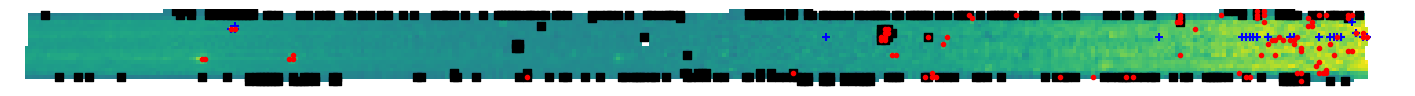

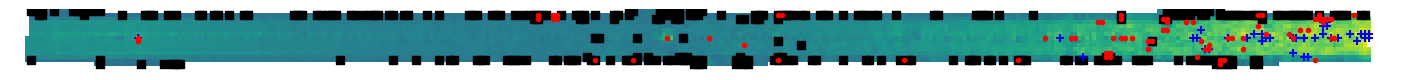

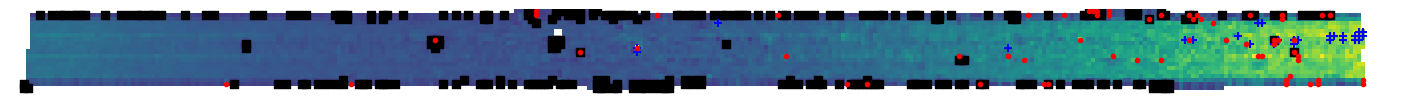

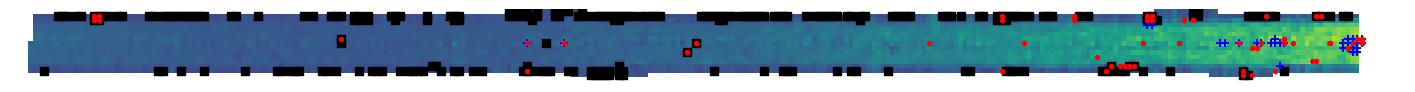

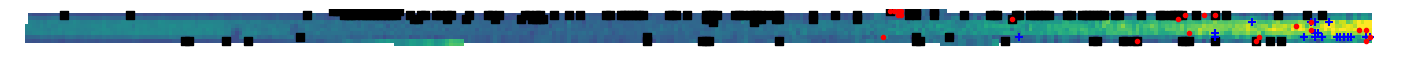

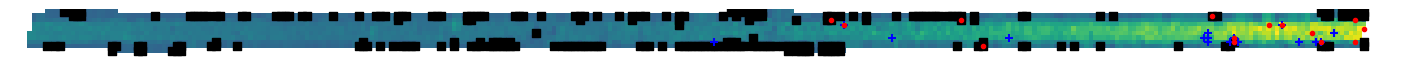

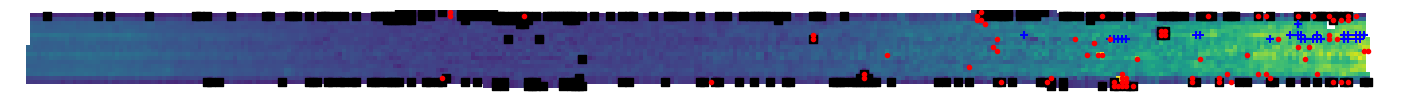

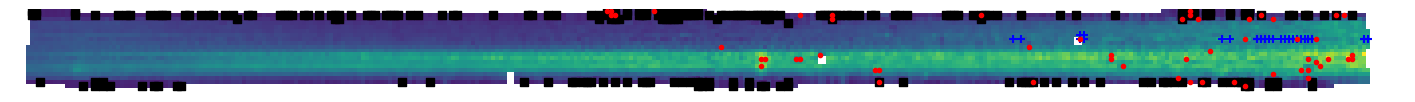

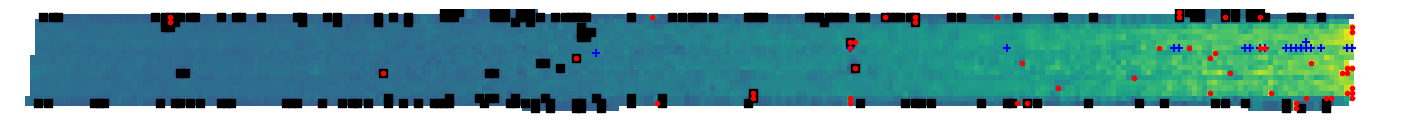

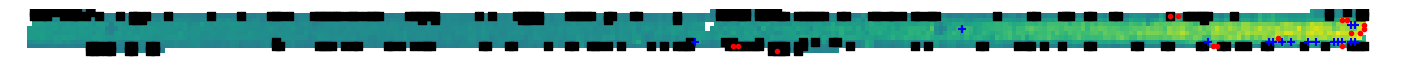

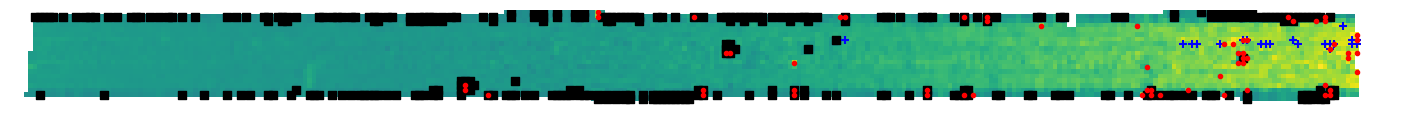

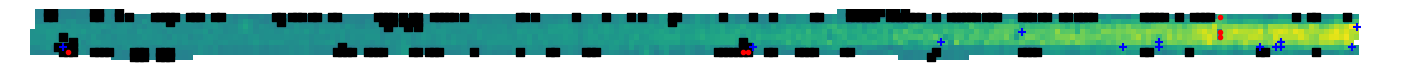

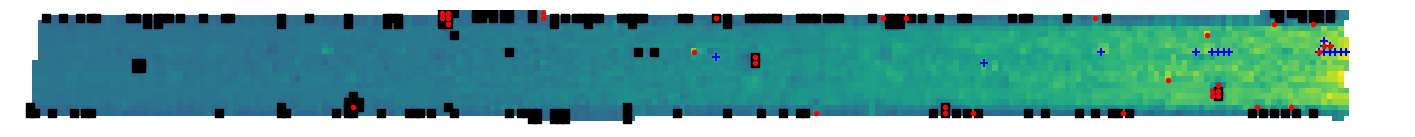

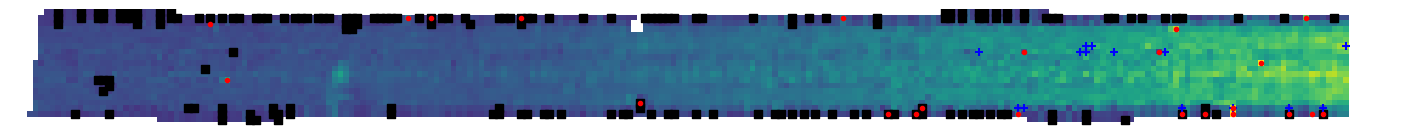

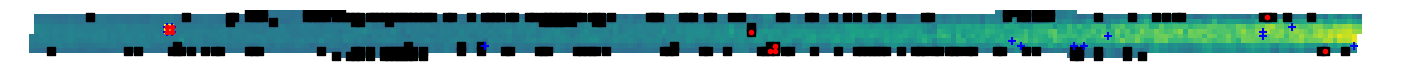

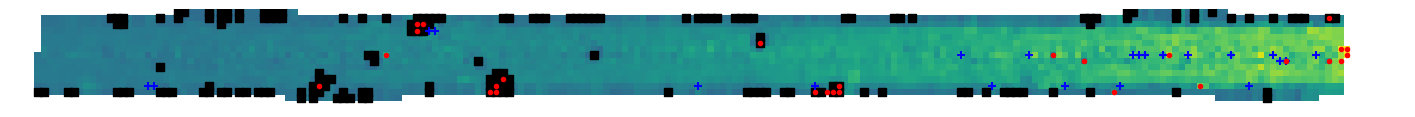

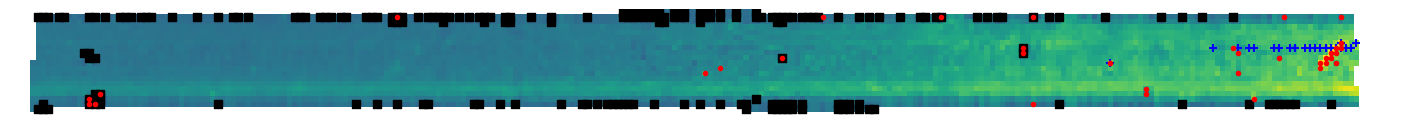

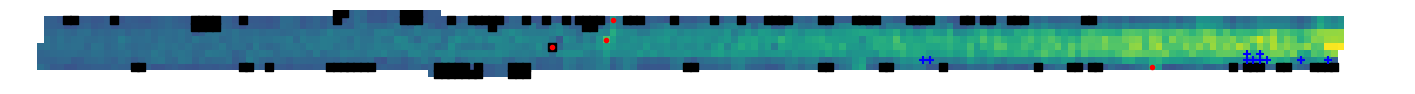

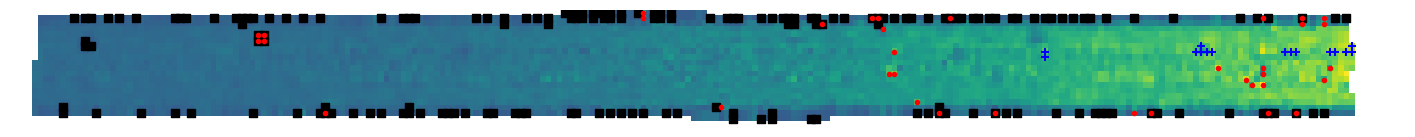

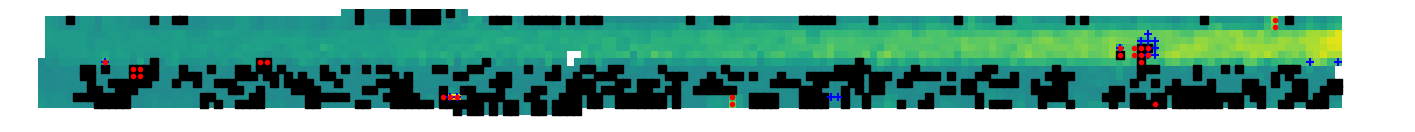

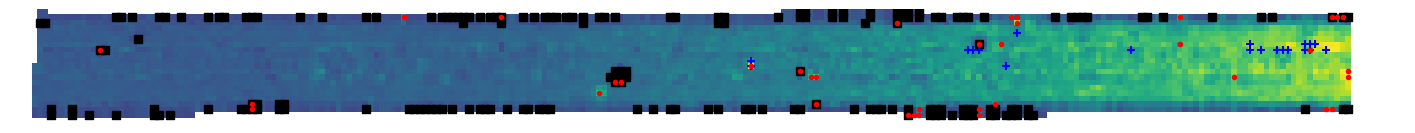

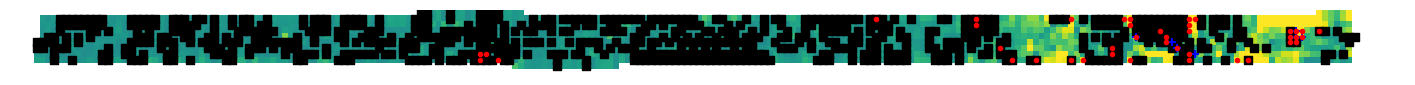

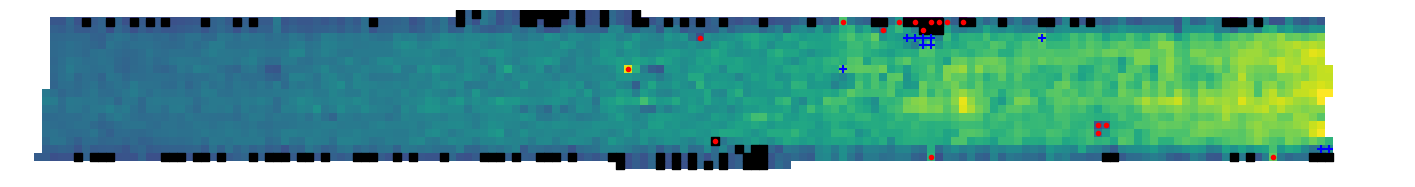

In [137]:
for slit in model.slits:
	data = slit.data.copy()
	error = slit.err.copy()
	masking(data,error,source=BBStep.getSourcePosition(slit))

	plt.show()